# Predicting Bike Rentals in Washington

## Introduction 

In this project I am going to use different algotithms to predict the number of bikes people rented in a given hour of a day in Washington, D.C. The data comes from [UCI webside](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset) and contains over 17,000 rows of bike rentals.

### Summary of results

The best results we could achieve using the Random Forest model.

## Data exploration

In [266]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [267]:
bike_rentals = pd.read_csv('data//bike_rental_hour.csv')

bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Lets take a look at he distribution of bike rentals.

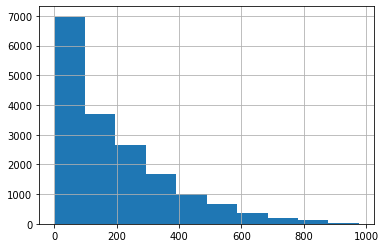

In [268]:
bike_rentals['cnt'].hist()

We can see that the distrubution is right skewed. Which means that there is more times where bikes are not fully occupied. Lets check what is the correlation between columns.

In [269]:
bike_rentals.corr()['cnt'].sort_values(ascending=False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

It looks like *registered and casual* are the ones most correlated. This is becasue they describe the number od casual and registered riders respectively and sum up to cnt, which is a total number of riders. They won't help us with the predictions because may cause data leaks. Its better to drop them.

## Data cleaning

In [270]:
bike_rentals.drop(['registered','casual'],inplace=True,axis=1)

In *hr* column which describes the specific hour at which the measurement was made we can see 24 unique values. Which can make quite a big impact on our model trying to predict a specific hour. Lets combine similar times together and create labels like:
- morning
- afternoon
- evening
- night

In [271]:
print(bike_rentals['hr'].unique())

def time_labels(val):
    if val>6 and val <=12:
        return 1 #morning
    elif val>12 and val<=18:
        return 2 #afternoon
    elif val>18:
        return 3 #evening
    elif val<=6:
        return 4 #night

# adding new labels
bike_rentals['time_label'] = bike_rentals['hr'].apply(time_labels)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [272]:
# sanity check
bike_rentals[['hr','time_label']]

,hr,time_label
0,0,4
1,1,4
2,2,4
3,3,4
4,4,4
...,...,...
17374,19,3
17375,20,3
17376,21,3
17377,22,3


## Model selection

In [273]:
# spliting data into train and test set
np.random.seed(1)
index = np.random.permutation(bike_rentals.index)
train = bike_rentals.iloc[:round(index.shape[0]*0.8)].copy()
test = bike_rentals.iloc[round(index.shape[0]*0.8):].copy()

train.shape[0], test.shape[0]

(13903, 3476)

### Linear regression

In [274]:
# correlation check
bike_rentals.corr()['cnt'].sort_values(ascending=False)

cnt           1.000000
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
time_label   -0.494422
Name: cnt, dtype: float64

Lets select features to fit in our model. Linear regression model works best when features are linearly correlated to the target variable but also uncorrelated witch each other. For example *temp and atemp* are both describing the same so we should take only one of them. *hr* we can ignore once we introduced *time_label*. Some of the columns like *yr and instant* don't really say anything.

In other words they do not describe the same thing. In general the linear regression model is quite resistant to overfitting but can be not the most accurate due to its linear nature. 

In [282]:
features = ['temp','hum','time_label']
target= 'cnt'

lr = LinearRegression()
lr.fit(train[features],train[target])
predictions = lr.predict(test[features])
rmse = mean_squared_error(test[target],predictions,squared=False)
rmse

187.9509022085043

I have selected RMSE to calculate the error. Next lets try Decission tree algorithm so we can compare errors.

### Decision Tree

In [293]:
attributes = bike_rentals.columns
attributes = attributes.drop(['instant','dteday','cnt'])
attributes
tree = DecisionTreeRegressor(max_depth=15, min_samples_leaf=6,random_state=1)
tree.fit(train[attributes],train[target])
predictions_train = tree.predict(train[attributes])
rmse_train = mean_squared_error(test[target],predictions,squared=False)
predictions = tree.predict(test[attributes])
rmse = mean_squared_error(test[target],predictions,squared=False)

# train and test error
rmse_train, rmse

(79.59358376355401, 79.59358376355401)

The Decision Tree model is subject to overtifing when the tree is to complex. The easiest way to check that is to compare prediction error made on train set to that on test set. If error on train set is significantly lower then error on test set then it means that our model is overfited. We can adjust the leaf criteria and max depth of the tree to change it. While error in not increasing which may indicate that we simplified our model to much we can stick to that adjustment.

As we can see Decision Tree model was able to significantly reduce the error.

### Random Forest

In [296]:
forest = RandomForestRegressor(n_estimators=20, max_depth=40, random_state=1)
forest.fit(train[attributes],train[target])
predictions_train = forest.predict(train[attributes])
rmse_train = mean_squared_error(test[target],predictions,squared=False)
predictions = forest.predict(test[attributes])
rmse = mean_squared_error(test[target],predictions,squared=False)

# train and test error
rmse_train, rmse

(72.43664749542866, 72.43664749542866)

Using the Random Forest model we achieved the lowest error. This algorithm can reduce an error from a single decision tree by creating multiple decision tree models and calculating the final value basend on all of them. This model is also much more resistant to overfiting. The main weakness is that its computensional costly to train model on big data. 

## Conclusion

By testing three different models we got the best resuts using the Random Forest.